In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("CA_data.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [128]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
print(missing_percentage)

id                                0
taxi_id                           0
trip_start_timestamp              0
trip_end_timestamp               11
trip_seconds                     50
trip_miles                       11
pickup_community_area         14485
dropoff_community_area        19567
fare                             20
tips                             20
tolls                         10153
extras                           20
trip_total                       20
payment_type                      0
company                           0
pickup_centroid_latitude      14458
pickup_centroid_longitude     14458
dropoff_centroid_latitude     18875
dropoff_centroid_longitude    18875
dtype: int64


In [129]:
# Define public holidays
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

# Convert trip_start_timestamp to datetime
train['trip_start_timestamp'] = pd.to_datetime(train['trip_start_timestamp'])

# Add is_working_day
train['is_working_day'] = np.where(
    (train['trip_start_timestamp'].dt.weekday.isin(range(0, 5))) & 
    (~train['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays)), 
    1, 0
)

# Add is_rush_hour
train['is_rush_hour'] = np.where(
    ((train['trip_start_timestamp'].dt.hour.isin([7, 8, 9]) &
      (train['trip_start_timestamp'].dt.minute <= 59)) |
     (train['trip_start_timestamp'].dt.hour.isin([16, 17, 18]) &
      (train['trip_start_timestamp'].dt.minute <= 59))) &
    (train['is_working_day'] == 1),
    1, 0
)

In [144]:
train.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,extras,trip_total,company,pickup_centroid_latitude,...,dropoff_centroid_longitude,is_working_day,is_rush_hour,pickup_community_area_mode,dropoff_community_area_mode,pickup_centroid_latitude_mode,pickup_centroid_longitude_mode,dropoff_centroid_latitude_mode,dropoff_centroid_longitude_mode,mile/time
0,420.0,0.0,8.0,8.0,6.00,0.0,0.0,6.00,29,41.898332,...,-87.626659,1,0,8.0,8.0,41.880994,-87.632746,41.884987,-87.620993,0.0
1,720.0,0.0,7.0,8.0,10.50,2.4,1.5,14.40,29,41.922686,...,-87.633308,1,0,8.0,8.0,41.880994,-87.632746,41.884987,-87.620993,0.0
2,180.0,0.0,28.0,28.0,4.75,2.0,1.5,8.25,29,41.885281,...,-87.642808,1,0,8.0,8.0,41.880994,-87.632746,41.884987,-87.620993,0.0
3,300.0,0.0,28.0,8.0,6.50,2.0,0.0,8.50,29,41.885300,...,-87.618868,1,0,8.0,8.0,41.880994,-87.632746,41.884987,-87.620993,0.0
4,960.0,0.0,76.0,8.0,13.50,2.0,6.0,21.50,29,41.979071,...,-87.877305,1,0,8.0,8.0,41.880994,-87.632746,41.884987,-87.620993,0.0


In [130]:
# Fill missing values for numeric columns with mode
for col in ['trip_seconds', 'trip_miles']:
    train[col] = train[col].fillna(train[col].mode()[0])

In [131]:
# Function to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Group by taxi_id and calculate modes
modes = train.groupby('taxi_id').agg({
    'pickup_community_area': get_mode,
    'dropoff_community_area': get_mode,
    'pickup_centroid_latitude': get_mode,
    'pickup_centroid_longitude': get_mode,
    'dropoff_centroid_latitude': get_mode,
    'dropoff_centroid_longitude': get_mode
}).reset_index()

# Merge with train
train = train.merge(modes, on='taxi_id', suffixes=('', '_mode'))

# Fill missing values with group modes
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    train[col] = train[col].fillna(train[f"{col}_mode"]).fillna(0)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
# Create mile/time column, avoiding division by zero
train['mile/time'] = train['trip_miles'] / train['trip_seconds']

# Replace any infinite or NaN values (caused by division by zero or missing data) with 0
train['mile/time'] = train['mile/time'].replace([np.inf, -np.inf], 0).fillna(0)

In [132]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
print(missing_percentage)

id                                     0
taxi_id                                0
trip_start_timestamp                   0
trip_end_timestamp                    11
trip_seconds                           0
trip_miles                             0
pickup_community_area                  0
dropoff_community_area                 0
fare                                  20
tips                                  20
tolls                              10153
extras                                20
trip_total                            20
payment_type                           0
company                                0
pickup_centroid_latitude               0
pickup_centroid_longitude              0
dropoff_centroid_latitude              0
dropoff_centroid_longitude             0
is_working_day                         0
is_rush_hour                           0
pickup_community_area_mode          2707
dropoff_community_area_mode         2685
pickup_centroid_latitude_mode       2680
pickup_centroid_

In [133]:
# Drop unnecessary columns
train = train.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id'
])

In [134]:
# Encode categorical columns
for col in train.select_dtypes('object').columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

In [135]:
# Split data into training, validation, and test sets
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [136]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
xgb_model = xgb.train(
    {
        'max_depth': 5,
        'eta': 0.2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
    },
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=500
)

[0]	train-auc:0.76028	val-auc:0.75797
[1]	train-auc:0.77290	val-auc:0.77192
[2]	train-auc:0.77841	val-auc:0.77699
[3]	train-auc:0.78294	val-auc:0.78153
[4]	train-auc:0.78420	val-auc:0.78247
[5]	train-auc:0.78618	val-auc:0.78446
[6]	train-auc:0.78751	val-auc:0.78578
[7]	train-auc:0.78943	val-auc:0.78773
[8]	train-auc:0.79067	val-auc:0.78862
[9]	train-auc:0.79145	val-auc:0.78908
[10]	train-auc:0.79210	val-auc:0.78944
[11]	train-auc:0.79362	val-auc:0.79063
[12]	train-auc:0.79431	val-auc:0.79125
[13]	train-auc:0.79494	val-auc:0.79178
[14]	train-auc:0.79534	val-auc:0.79193
[15]	train-auc:0.79558	val-auc:0.79217
[16]	train-auc:0.79609	val-auc:0.79251
[17]	train-auc:0.79666	val-auc:0.79277
[18]	train-auc:0.79710	val-auc:0.79308
[19]	train-auc:0.79753	val-auc:0.79332
[20]	train-auc:0.79784	val-auc:0.79350
[21]	train-auc:0.79850	val-auc:0.79378
[22]	train-auc:0.79888	val-auc:0.79394
[23]	train-auc:0.79925	val-auc:0.79428
[24]	train-auc:0.79971	val-auc:0.79463
[25]	train-auc:0.80018	val-auc:0.79

In [137]:
# Predict on test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")

Confusion Matrix:
[[19692  2093]
 [ 5124  3091]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.85     21785
           1       0.60      0.38      0.46      8215

    accuracy                           0.76     30000
   macro avg       0.69      0.64      0.65     30000
weighted avg       0.74      0.76      0.74     30000

AUC: 0.8001


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


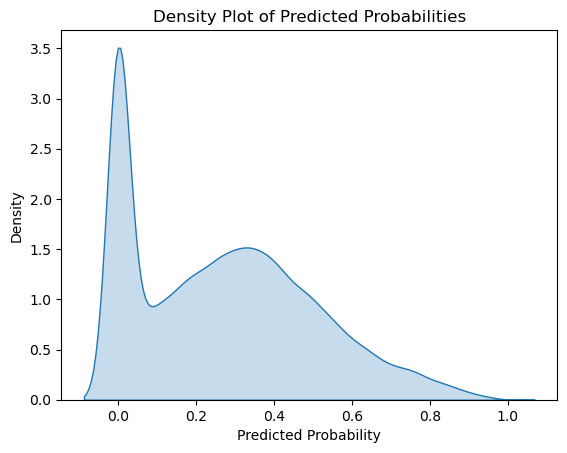

In [138]:
# Plot density of predictions
sns.kdeplot(y_pred, label="Predicted Probabilities", fill=True)
plt.title("Density Plot of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.show()

In [139]:
# Predict probabilities on the test set
y_pred_prob_xgb = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_xgb = (y_pred_prob_xgb >= 0.5).astype(int)

In [140]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_xgb.ravel()

Confusion Matrix:
[[19692  2093]
 [ 5124  3091]]


In [141]:
# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy_xgb = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy: {balanced_accuracy_xgb:.4f}")

Balanced Accuracy: 0.6401


In [142]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy (Sklearn): {balanced_accuracy_xgb:.4f}")

Balanced Accuracy (Sklearn): 0.6401


In [ ]:
# Extract feature importance metrics
importance_gain = xgb_model.get_score(importance_type='gain')
importance_cover = xgb_model.get_score(importance_type='cover')
importance_weight = xgb_model.get_score(importance_type='weight')

# Combine into a DataFrame
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),  # Feature names
    'Gain': list(importance_gain.values()),   # Gain values
    'Cover': [importance_cover.get(k, 0) for k in importance_gain.keys()],  # Cover values
    'Frequency': [importance_weight.get(k, 0) for k in importance_gain.keys()]  # Frequency (weight)
}).sort_values(by='Gain', ascending=False)  # Sort by Gain

print(feature_importance_df)

                            Feature  Importance
20                        mile/time      1722.0
0                      trip_seconds      1646.0
7                        trip_total      1152.0
1                        trip_miles      1138.0
8                           company      1093.0
12       dropoff_centroid_longitude      1068.0
4                              fare      1043.0
11        dropoff_centroid_latitude       945.0
10        pickup_centroid_longitude       929.0
9          pickup_centroid_latitude       917.0
19  dropoff_centroid_longitude_mode       892.0
5                              tips       828.0
18   dropoff_centroid_latitude_mode       811.0
16    pickup_centroid_latitude_mode       777.0
17   pickup_centroid_longitude_mode       757.0
6                            extras       747.0
3            dropoff_community_area       540.0
2             pickup_community_area       425.0
14       pickup_community_area_mode       352.0
15      dropoff_community_area_mode     

## TRAIN WITH LG INSTEAD

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [66]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
#missing_percentage = train.isna().sum() / len(train)

print(missing_percentage)

trip_seconds                          0
trip_miles                            0
pickup_community_area                 0
dropoff_community_area                0
fare                                 20
tips                                 20
extras                               20
trip_total                           20
company                               0
pickup_centroid_latitude              0
pickup_centroid_longitude             0
dropoff_centroid_latitude             0
dropoff_centroid_longitude            0
is_working_day                        0
is_rush_hour                          0
pickup_community_area_mode         2707
dropoff_community_area_mode        2685
pickup_centroid_latitude_mode      2680
pickup_centroid_longitude_mode     2680
dropoff_centroid_latitude_mode     2685
dropoff_centroid_longitude_mode    2685
dtype: int64


In [65]:
# Fill NaN values in X_train and X_test with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [69]:
# Define features (X) and target variable (y)
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [73]:
# Fill NaN values in X_train and X_test with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

In [71]:
# Initialize logistic regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [74]:
# Predict on the validation set
y_val_pred = logreg_model.predict(X_val)
y_val_pred_prob = logreg_model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class

In [75]:
# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation AUC: {auc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

Validation Accuracy: 0.7227
Validation AUC: 0.7266
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     21807
           1       0.39      0.03      0.05      8193

    accuracy                           0.72     30000
   macro avg       0.56      0.51      0.44     30000
weighted avg       0.64      0.72      0.62     30000

Confusion Matrix:
[[21465   342]
 [ 7977   216]]


In [76]:
# Predict on the test set
y_test_pred = logreg_model.predict(X_test)
y_test_pred_prob = logreg_model.predict_proba(X_test)[:, 1]

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# AUC
test_auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"Test AUC: {test_auc:.4f}")

# Classification Report
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(conf_matrix_test)

Test Accuracy: 0.7213
Test AUC: 0.7219
Test Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     21785
           1       0.36      0.02      0.04      8215

    accuracy                           0.72     30000
   macro avg       0.54      0.50      0.44     30000
weighted avg       0.63      0.72      0.62     30000

Test Confusion Matrix:
[[21450   335]
 [ 8025   190]]


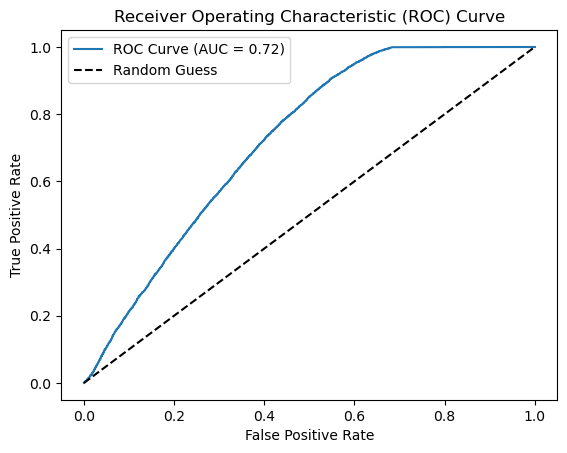

In [77]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

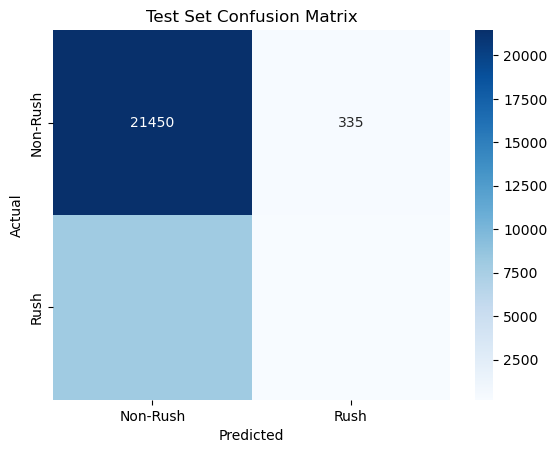

In [78]:
import seaborn as sns

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rush', 'Rush'], yticklabels=['Non-Rush', 'Rush'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()

In [79]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Predict binary outcomes on the test set
y_pred = logreg_model.predict(X_test)

In [80]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy (Manual): {balanced_accuracy:.4f}")

Confusion Matrix:
[[21450   335]
 [ 8025   190]]
Balanced Accuracy (Manual): 0.5039
